In [21]:
import os
import json
from collections import defaultdict
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt

def load_clevr_scene_summary(
    clevr_root: str,
    split: str = "train",
    include_material_size: bool = False,
    position_type: str = "3d",   # "3d" | "pixel" | "both"
) -> Dict[str, List[Dict[str, Any]]]:
    """
    Return per-image aggregated object info from CLEVR scenes.

    Output format (per image):
      [
        {
          "shape": "cube",
          "color": "gray",
          "number": 2,
          "position": [...],  # list of positions of each object in that group
          # optional: "material": "...", "size": "..." if include_material_size=True and you want to group differently
        },
        ...
      ]

    Notes:
    - CLEVR scenes.json provides objects list with:
      - shape, color, material, size
      - 3d_coords (x,y,z) and pixel_coords (x,y,depth)
      - rotation (sometimes)
    - We aggregate by (shape,color) by default (matches your需求).
    """
    assert split in ["train", "val", "test"], "split must be train/val/test"
    assert position_type in ["3d", "pixel", "both"], "position_type must be 3d/pixel/both"

    scenes_path = os.path.join(clevr_root, "scenes", f"CLEVR_{split}_scenes.json")
    with open(scenes_path, "r", encoding="utf-8") as f:
        scenes_json = json.load(f)

    scenes = scenes_json["scenes"]

    # image_filename -> list of aggregated dicts
    per_image_summary: Dict[str, List[Dict[str, Any]]] = {}

    for scene in scenes:
        img_fn = scene.get("image_filename", None)
        if img_fn is None:
            # fallback: build from image_index if needed
            image_index = scene["image_index"]
            img_fn = f"CLEVR_{split}_{image_index:06d}.png"

        grouped = defaultdict(lambda: {"count": 0, "positions": []})

        for obj in scene["objects"]:
            shape = obj["shape"]
            color = obj["color"]

            key = (shape, color)

            # choose position payload
            pos_payload = {}
            if position_type in ["3d", "both"]:
                pos_payload["3d_coords"] = obj.get("3d_coords", None)
            if position_type in ["pixel", "both"]:
                pos_payload["pixel_coords"] = obj.get("pixel_coords", None)

            grouped[key]["count"] += 1
            grouped[key]["positions"].append(pos_payload if position_type == "both" else
                                            (obj.get("3d_coords") if position_type == "3d" else obj.get("pixel_coords")))

        # build final list in your desired style: shape: color: number: position
        out_list = []
        for (shape, color), v in grouped.items():
            item = {
                "shape": shape,
                "color": color,
                "number": v["count"],
                "position": v["positions"],  # list of positions
            }
            out_list.append(item)

        # stable ordering (optional)
        out_list.sort(key=lambda d: (d["shape"], d["color"]))

        per_image_summary[img_fn] = out_list

    return per_image_summary


# ---- Example usage ----
clevr_root = "./CLEVR_v1.0"
summary = load_clevr_scene_summary(
    clevr_root=clevr_root,
    split="train",
    include_material_size=False,
    position_type="both"  # "3d" or "pixel" or "both"
)



Image: CLEVR_train_000000.png

Image: CLEVR_train_000001.png

Image: CLEVR_train_000002.png



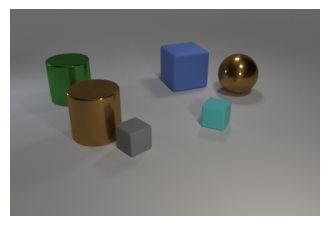

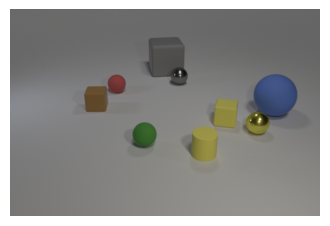

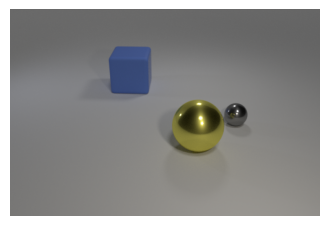

In [25]:
it = iter(summary.keys())

for i in range(3):
    some_img = next(it)
    print("Image:", some_img)
    # for item in summary[some_img]:
    #     print(f"{item['shape']} : {item['color']} : {item['number']} : {item['position'][:2]} ...")
    
    img_path = f"./CLEVR_v1.0/images/train/{some_img}"
    img = Image.open(img_path).convert("RGB")

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    print()


Scene summary:
  cube blue x1
  sphere gray x1
  sphere yellow x1


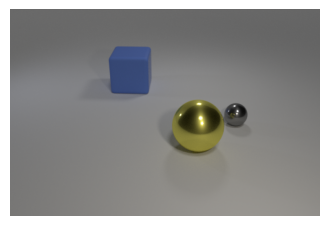

In [23]:
img_fn = some_img  # 你从 summary 里拿的
img_path = f"./CLEVR_v1.0/images/train/{img_fn}"

img = Image.open(img_path).convert("RGB")

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")

print("Scene summary:")
for it in summary[img_fn]:
    print(f"  {it['shape']} {it['color']} x{it['number']}")

plt.show()
